## what we are going to answer in that section

6. Who are the **top reviewers** (users with the most reviews)?
7. What are the **most frequent words** in review titles or review content? (Text analysis)
8. Is there a noticeable trend in **review ratings** vs. **review length** (longer reviews = higher/lower ratings)?

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.stats import (
    ttest_1samp, ttest_ind, ttest_rel,
    norm, chi2, f_oneway, chi2_contingency, chisquare
)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/amazon_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

# clean 
df['actual_price'] = (df['actual_price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False))
df['discounted_price'] = (df['discounted_price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False))
df['discount_percentage'] = (df['discount_percentage'].str.replace('%', '', regex=False).str.replace(',', '', regex=False))
df['rating_count'] = (df['rating_count'].str.replace(',', '', regex=False))
df['rating'] = (df['rating'].str.replace('|', '0', regex=False))


df['actual_price']= df['actual_price'].astype(float)
df['discounted_price']= df['discounted_price'].astype(float)
df['discount_percentage']= df['discount_percentage'].astype(float)
df['rating_count']= df['rating_count'].astype(float)
df['rating']= df['rating'].astype(float)

# turn discount_percentage to float percentage
df['discount_percentage']= df['discount_percentage'].apply(lambda x: x/100)

# make the discounted_price more accurate
df['discounted_price'] = (df['actual_price'] * (1 - df['discount_percentage']))


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1465 non-null   object 
 1   product_name         1465 non-null   object 
 2   category             1465 non-null   object 
 3   discounted_price     1465 non-null   float64
 4   actual_price         1465 non-null   float64
 5   discount_percentage  1465 non-null   float64
 6   rating               1465 non-null   float64
 7   rating_count         1463 non-null   float64
 8   about_product        1465 non-null   object 
 9   user_id              1465 non-null   object 
 10  user_name            1465 non-null   object 
 11  review_id            1465 non-null   object 
 12  review_title         1465 non-null   object 
 13  review_content       1465 non-null   object 
 14  img_link             1465 non-null   object 
 15  product_link         1465 non-null   o

In [97]:
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,395.64,1099.0,0.64,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,198.93,349.0,0.43,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,189.90,1899.0,0.90,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,328.53,699.0,0.53,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,155.61,399.0,0.61,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [98]:
df['category_clean']= df['category'].apply(lambda x: x.split('|')[-1])
df['user_name_clean'] = df['user_name'].apply(
    lambda x: ', '.join(x.split(',')[0:2]) if isinstance(x, str) and ',' in x else x
)


df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,category_clean,user_name_clean
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,395.64,1099.0,0.64,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,USBCables,"Manav, Adarsh gupta"
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,198.93,349.0,0.43,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,USBCables,"ArdKn, Nirbhay kumar"
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,189.90,1899.0,0.90,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,USBCables,"Kunal, Himanshu"
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,328.53,699.0,0.53,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,USBCables,"Omkar dhale, JD"
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,155.61,399.0,0.61,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,USBCables,"rahuls6099, Swasat Borah"


### 6. Who are the **top reviewers** (users with the most reviews)?

In [99]:
df_grouped= df.groupby('user_name_clean')[['user_id', 'category_clean']].value_counts().reset_index().sort_values(by='count', ascending=False).head(10).copy()
df_grouped.reset_index().drop(columns='index')


,user_name_clean,user_id,category_clean,count
0,"$@|\|TO$|-|, Sethu madhav","AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA,AE55KTFVNXYFD5FPY...",USBCables,10
1,"Manav, Adarsh gupta","AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...",USBCables,8
2,"Satheesh Kadiam, Pritom Chakraborty","AGAELRYPMTG5SADZPDYB343EASAA,AGFN4JODOM2NTFCJQ...",Smartphones,8
3,"Omkar dhale, JD","AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...",USBCables,7
4,"ArdKn, Nirbhay kumar","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...",USBCables,7
5,"Prashant, Sumesh Sundararajan","AG44HJB2AMIVHAGQZ2WGWONERKCA,AHL2FABQV6XAHZN54...",MicroSD,6
6,"siddharth patnaik, Dr Sunilkumar H","AHWRZWPCTG6ICA7WTNLNNZXWFI5Q,AF2AASVYVSROFD7FX...",Smartphones,6
7,"Actual user, Shanti lal Gurjar","AGU76WKSU62DUNTPCMTC4FCUNRTQ,AEOVR6JEQTAC77BXE...",USBCables,5
8,"Manoj maddheshiya, Manoj Kumar Sahoo","AHEVOQADJSSRX7DS325HSFLMP7VQ,AG7XYZRCSKX6G2OLO...",SmartTelevisions,5
9,"Ayush, ROHIT A.","AFSMISGEYDYIP3Z42UTQU4AKOYZQ,AF5ILQY4KFDTO5XHH...",SmartTelevisions,5


### 7. What are the **most frequent words** in review titles or review content?

## note: 

## 🧩 1. `import re`

### What it means:

`re` stands for **regular expressions** — it’s a built-in Python module used to:

* **search**,
* **replace**,
* **split**, or
* **match** text using *patterns* instead of exact words.

✅ Example:

```python
import re
re.sub('cat', 'dog', 'my cat runs fast')
```

→ `'my dog runs fast'`

Here it replaces “cat” with “dog”.

But the real power comes from using **patterns**, like `'[^a-zA-Z0-9\s]'`.

---

## 🧠 2. `'[^a-zA-Z0-9\s]'` — step by step

Let’s break this small piece into **4 mini parts**:

---

### 🧩 (a) Square brackets `[ ]`

They mean **a set of allowed characters**.

Example:

* `[abc]` → matches **a**, **b**, or **c**
* `[0-9]` → matches any **digit**
* `[a-z]` → matches any lowercase **letter**

So `[a-zA-Z0-9\s]` means:

> any lowercase letter (a–z), uppercase letter (A–Z), number (0–9), or whitespace (`\s`).

---

### 🧩 (b) `^` inside the brackets

When `^` is inside `[ ]` **and at the start**, it means **NOT these**.

So:

```
[^a-zA-Z0-9\s]
```

means:

> match any character that is **not** a letter, number, or space.

---

### 🧩 (c) `\s`

`\s` stands for **space characters** — that includes:

* normal space `" "`
* tab `\t`
* new line `\n`

So this keeps your words separated by spaces even after cleaning.

---

### 🧩 (d) The full pattern `'[^a-zA-Z0-9\s]'`

Now putting it together:

> “Find any character that is **NOT** a letter (a–z or A–Z), a number (0–9), or a space.”

This includes:

* punctuation marks like `!`, `.`, `,`, `?`, `:`, `;`, `'`, `"`
* symbols like `@`, `#`, `$`, `%`, `&`, `*`, etc.

---

### ✅ 3. What it does in your code

When you write:

```python
df['review_content'] = df['review_content'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
```

It says:

> “Go through each review and remove every character that is not a letter, number, or space.”

So this:

```
"Great product!!! Works well :)"
```

becomes:

```
"Great product Works well "
```

All punctuation is gone, but words and spaces stay intact.

---

### 🧩 4. Why the `r''` before the pattern?

`r''` means a **raw string** — it tells Python:

> “Don’t treat backslashes like `\n` or `\t` as special characters.”

So:

* `r'\s'` → means a literal regex space symbol
* without the `r`, `'\s'` might confuse Python

✅ Always use `r''` for regex patterns to avoid hidden errors.

---

### 🧠 Summary Table

| Symbol            | Meaning                       | Example                |
| ----------------- | ----------------------------- | ---------------------- |
| `[]`              | Character set                 | `[abc]` → a, b, or c   |
| `^` (inside `[]`) | NOT these characters          | `[^0-9]` → not a digit |
| `a-zA-Z0-9`       | Letters and digits            | `a`, `F`, `7`, etc.    |
| `\s`              | Spaces, tabs, newlines        | `" "` or `\n`          |
| `r''`             | Raw string (don’t escape `\`) | `r'\s'` works safely   |



In [100]:
import re

df['review_content'] = df['review_content'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower()


In [101]:
words= df['review_content'].apply(lambda x: x.split(' ')).sum() # sum to make all lists combined into on list

In [102]:
good_words = [
    'good', 'great', 'excellent', 'amazing', 'perfect', 'useful', 'durable', 'nice',
    'worth', 'satisfied', 'happy', 'recommend', 'comfortable', 'fast', 'reliable',
    'value', 'beautiful', 'easy', 'strong', 'love', 'awesome', 'best', 'compact',
    'efficient', 'smooth', 'affordable', 'clean', 'neat', 'fine', 'stable',
    'helpful', 'trustworthy', 'enjoy', 'cool', 'fantastic', 'powerful', 'friendly',
    'responsive', 'solid', 'bright', 'handy', 'soft', 'quiet', 'lasting', 'fit',
    'pleased', 'superb', 'impressive', 'high-quality'
]

bad_words = [
    'bad', 'poor', 'worst', 'broken', 'disappointed', 'cheap', 'useless', 'slow',
    'damaged', 'waste', 'boring', 'fragile', 'dirty', 'defective', 'annoying',
    'uncomfortable', 'weak', 'expensive', 'ugly', 'unreliable', 'fake', 'terrible',
    'dull', 'difficult', 'incomplete', 'flimsy', 'stopped', 'problem', 'noisy',
    'issue', 'missing', 'hate', 'low', 'worse', 'cracked', 'error', 'unhappy',
    'awful', 'laggy', 'delay', 'hard', 'return', 'refund', 'wrong', 'unhelpful',
    'unworthy', 'regret', 'messy'
]

good_words_df=[]
bad_words_df=[]

for word in words:
    if word in good_words:
        good_words_df.append(word)

for word in words:
    if word in bad_words:
        bad_words_df.append(word)


    

In [103]:
from collections import Counter

word_counts_good = Counter(good_words_df)
word_counts_bad = Counter(bad_words_df)

In [104]:
word_counts_df_g = pd.DataFrame(word_counts_good.items(), columns=['word', 'count'])
word_counts_df_g.sort_values(by='count', ascending=False).reset_index().drop(columns='index').head(20)

,word,count
0,good,4455
1,easy,760
2,great,565
3,best,564
4,fast,502
5,nice,460
6,fine,427
7,worth,362
8,value,346
9,recommend,233


In [105]:
word_counts_df_b = pd.DataFrame(word_counts_bad.items(), columns=['word', 'count'])
word_counts_df_b.sort_values(by='count', ascending=False).reset_index().drop(columns='index').head(20)

,word,count
0,problem,308
1,issue,303
2,low,271
3,bad,203
4,cheap,159
5,hard,145
6,stopped,106
7,poor,90
8,return,90
9,expensive,88


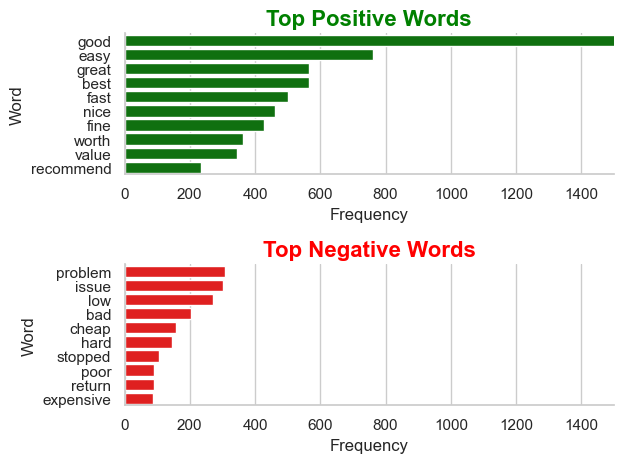

In [106]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(2, 1)  # 2 rows, 1 column

# --- Positive words ---
sns.barplot(
    x='count',
    y='word',
    data=word_counts_df_g.sort_values(by='count', ascending=False).head(10),
    color='green',
    ax=ax[0]
)
ax[0].set_title('Top Positive Words', fontsize=16, weight='bold', color='green')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Word')
ax[0].set_xlim(0, 1500)

# --- Negative words ---
sns.barplot(
    x='count',
    y='word',
    data=word_counts_df_b.sort_values(by='count', ascending=False).head(10),
    color='red',
    ax=ax[1]
)
ax[1].set_title('Top Negative Words', fontsize=16, weight='bold', color='red')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Word')
ax[1].set_xlim(0, 1500)


sns.despine()
plt.tight_layout()
plt.show()

### 8. Is there a noticeable trend in **review ratings** vs. **review length** (longer reviews = higher/lower ratings)?

In [109]:
import re

df['review_words_count'] = df['review_content'].apply(
    lambda x: len(re.findall(r'\b\w+\b', str(x)))
)

df_plot = df[['review_words_count', 'rating']].sort_values(by='review_words_count')
df_plot


,review_words_count,rating
324,11,5.0
302,12,4.2
2,13,3.9
623,13,3.9
1351,13,4.0
...,...,...
976,2080,4.6
41,2118,4.3
718,2248,4.3
656,2380,3.8


Correlation coefficient: 0.0691880513483714
p-value: 0.008070425293893131


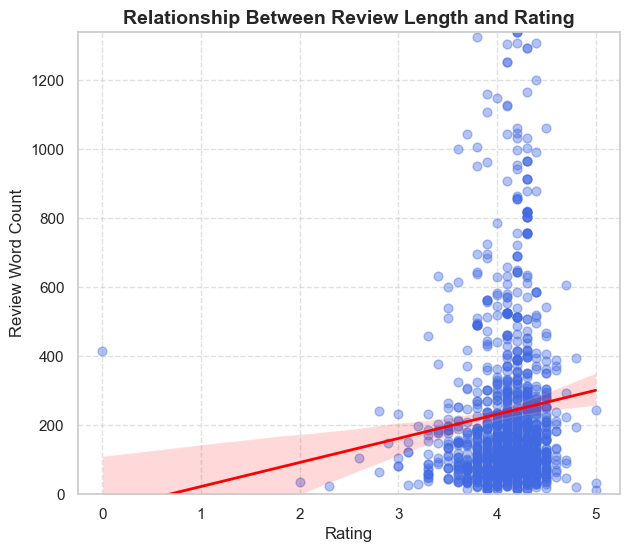

In [110]:
from scipy.stats import pearsonr

r, p = pearsonr(df_plot['review_words_count'], df_plot['rating'])
print("Correlation coefficient:", r)
print("p-value:", p)

#----------------------------------------------------------------#

plt.figure(figsize=(7, 6))

sns.regplot(
    x='rating',
    y='review_words_count',
    data=df,
    scatter_kws={'alpha': 0.4, 's': 40, 'color': 'royalblue'},  # smaller, more transparent points
    line_kws={'color': 'red', 'linewidth': 2},  # highlight trend line
)

plt.title('Relationship Between Review Length and Rating', fontsize=14, weight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Review Word Count', fontsize=12)
plt.ylim(0, df['review_words_count'].quantile(0.98))  # cut extreme outliers for clarity
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()